In [1]:
# Testing whether the projected LM approach works
#  Without the constraints, the problem admits both +x and -x as solutions.
# With the constraints, we should only get +x

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.optimizers.tensorflow.lma import LMA

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
x_true = np.ones(20, dtype='float32') * 2

random_mat = np.random.randn(20,20)
A = random_mat @ random_mat

# The output data could be from x=2 or x=-2.
y = np.reshape(A @ x_true**2, [-1])

In [11]:
x_guess = np.random.randn(20).astype('float32') * 10

# LMA - linesearch for damping param

In [15]:
tf.reset_default_graph()

# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.1, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
def loss_fn(y_pred):
    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)

preds_constr_t = preds_fn(var_constr)
loss_constr_t = loss_fn(preds_constr_t)
error_constr_t = tf.reduce_sum((var_constr - x_true_t)**2) / x_true.size

preds_unconstr_t = preds_fn(var_unconstr)
loss_unconstr_t = loss_fn(preds_unconstr_t)
error_unconstr_t = tf.reduce_sum((var_unconstr - x_true_t)**2)  / x_true.size

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', mu=1e-4, 
                   diag_hessian_fn=lambda x: 1.0,
                   mu_contraction=0.25, 
                   mu_expansion=4.0,
                   min_cg_tol=1e-5, assert_tolerances=False)
proj_lma_min_op = proj_lma_opt.minimize()

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', mu=1e-4,
                       diag_hessian_fn=lambda x: 1.0,
                       mu_contraction=0.25,
                       mu_expansion=4.0,
                       min_cg_tol=1e-5, assert_tolerances=False)
unconstr_lma_min_op = unconstr_lma_opt.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [16]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(200):
    session.run([proj_lma_min_op, unconstr_lma_min_op])
    l1, l2, e1, e2 = session.run([loss_constr_t, loss_unconstr_t, error_constr_t, error_unconstr_t])
    losses_constr.append(l1)
    errors_constr.append(e1)
    losses_unconstr.append(l2)
    errors_unconstr.append(e2)

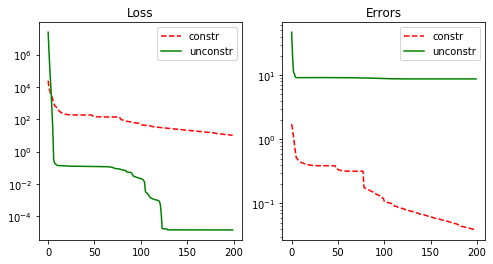

In [17]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(losses_constr, color='red', ls='--', label='constr')
plt.plot(losses_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(errors_constr, color='red', ls='--', label='constr')
plt.plot(errors_unconstr, color='green', label='unconstr')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [18]:
session.run([var_unconstr, var_constr])

[array([-1.7203963 ,  0.4249166 , -2.7824402 ,  2.0181494 , -2.630975  ,
         2.1386611 , -1.9505926 , -1.6628932 ,  2.2243211 , -1.855572  ,
         2.390224  , -2.6916802 , -2.476908  ,  1.4224641 , -0.00722936,
         2.518274  ,  2.9308245 ,  3.0213323 ,  2.390731  , -2.6059122 ],
       dtype=float32),
 array([2.0685525, 2.0769415, 1.7288269, 1.8855394, 2.0332649, 2.045604 ,
        1.7943376, 2.1      , 1.6871872, 2.04233  , 1.927038 , 1.812147 ,
        1.7101033, 2.1      , 2.1      , 1.7658204, 1.81355  , 1.5800934,
        1.905693 , 1.6789714], dtype=float32)]

In [19]:
session.run([proj_lma_opt._iteration, proj_lma_opt._total_cg_iterations, proj_lma_opt._total_proj_ls_iterations]), session.run([unconstr_lma_opt._iteration, unconstr_lma_opt._total_cg_iterations])

([221, 5634, 356], [294, 6422])

In [20]:
session.run([error_constr_t, error_unconstr_t])

[0.03874566, 8.73569]

# LM without linesearch 

In [21]:
tf.reset_default_graph()

# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.01, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
def loss_fn(y_pred):
    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)

preds_constr_t = preds_fn(var_constr)
loss_constr_t = loss_fn(preds_constr_t)
error_constr_t = tf.reduce_sum((var_constr - x_true_t)**2) / x_true.size

preds_unconstr_t = preds_fn(var_unconstr)
loss_unconstr_t = loss_fn(preds_unconstr_t)
error_unconstr_t = tf.reduce_sum((var_unconstr - x_true_t)**2)  / x_true.size

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', min_cg_tol=1e-5, assert_tolerances=False, max_mu_linesearch_iters=1)
proj_lma_min_op = proj_lma_opt.minimize()

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', min_cg_tol=1e-5, assert_tolerances=False, max_mu_linesearch_iters=1)
unconstr_lma_min_op = unconstr_lma_opt.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [22]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(200):
    session.run([proj_lma_min_op, unconstr_lma_min_op])
    l1, l2, e1, e2 = session.run([loss_constr_t, loss_unconstr_t, error_constr_t, error_unconstr_t])
    losses_constr.append(l1)
    errors_constr.append(e1)
    losses_unconstr.append(l2)
    errors_unconstr.append(e2)

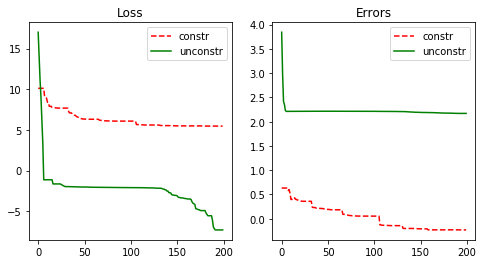

In [23]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(np.log(losses_constr), color='red', ls='--', label='constr')
plt.plot(np.log(losses_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(np.log(errors_constr), color='red', ls='--', label='constr')
plt.plot(np.log(errors_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [46]:
session.run([var_unconstr, var_constr])

[array([-2.1369646,  2.0638247, -2.2197802, -2.0885696, -2.1276467,
        -1.9019428,  1.9102019, -2.043488 ,  2.1298995, -1.8409691,
         1.9180607, -1.9227175,  1.9892062,  2.121836 ,  2.0755205,
         1.7770355,  2.0393827, -2.1222312,  1.9264569, -1.8327581],
       dtype=float32),
 array([1.5849909, 1.8815885, 1.7835839, 1.8514143, 1.8844435, 1.9979963,
        2.0638566, 1.8968097, 2.0652344, 2.0567372, 2.071703 , 2.1      ,
        2.0923798, 1.5616138, 1.9883562, 2.1      , 1.7745427, 2.0696614,
        2.097848 , 2.0914986], dtype=float32)]

In [47]:
session.run([proj_lma_opt._iteration, proj_lma_opt._total_cg_iterations, proj_lma_opt._total_proj_ls_iterations]), session.run([unconstr_lma_opt._iteration, unconstr_lma_opt._total_cg_iterations])

([200, 2555, 254], [200, 3435])